## Data Science for Business 2021/22
### Mirko Trapani


# The impact of Covid-19 on the jobs market

### Objective

- identify which categories were the most affected by the pandemic, based on age, gender, studies and so on.

### How

- *a posteriori* what-if analysis using time series prediction
- we compare a prediction of years 2020-2021 against the actual data
- the prediction is based on previous years, until 2019

In [1]:
data_path = "~/data/"

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

##### Loading *incomplete* dataset

In [112]:
def prepare_dataset(path): 
    ds = pd.read_csv(path)
    ds["DATA"] = pd.to_datetime(ds["DATA"], dayfirst=True, errors="coerce")
    ds = ds.sort_values("DATA", ignore_index=True)
        
    # From previous labs we already know there is one record with invalid date, 
    # let's remove it
    ds = ds[ds['DATA'].notna()]
    
    # Creating column MESE e ANNO
    ds['MESE'] = ds['DATA'].dt.month
    ds['ANNO'] = ds['DATA'].dt.year
    
    # Create column TRIM so that data is divided in trimesters
    ds['TRIM'] = ds['MESE'].apply(lambda x : math.ceil(x/3))
    
    trims = [(x, y) for x in range(2016, 2022) for y in range(1, 5)]
    return ds.groupby(["ANNO", "TRIM"]).size().reindex(trims)

jobs = prepare_dataset(data_path + "Rapporti_di_lavoro_attivati.csv")
ceased = prepare_dataset(data_path + "Rapporti_di_lavoro_cessati.csv")

## Oh no, the data doesn't add up!
### +6M jobs in 10 years?
   
   

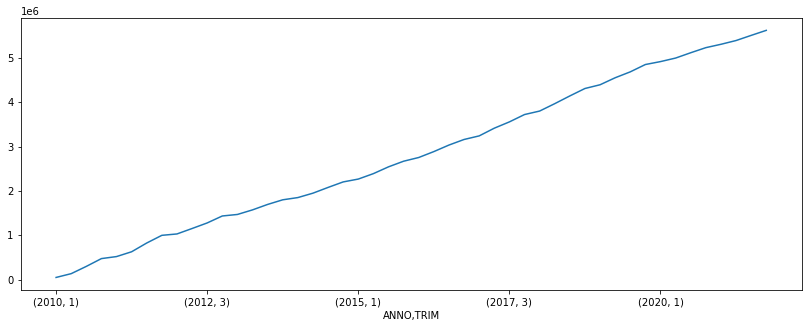

In [110]:
(jobs-ceased).cumsum()

## But, why?

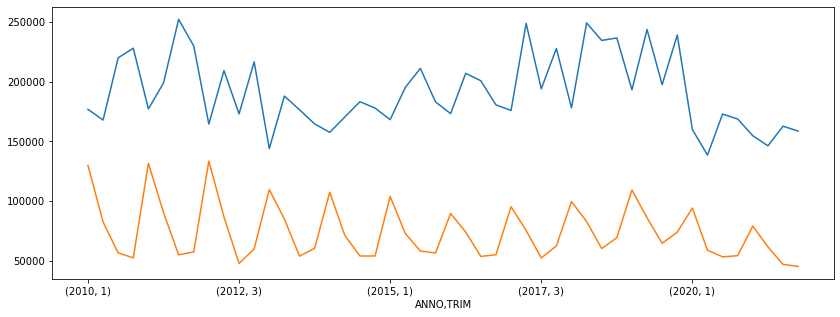

In [111]:
jobs.plot()
ceased.plot()

## According to official data, job contracts have increased by ~450k in 2015-2020 

![](./res/quadrante.png)

![](./res/pacman.png)

## Someone (or something) ate our data, what now?

# Another source of data!


![](./res/quadrante2.png)

https://quadrantelavoro.regione.lombardia.it
#### CVS exports available!

##### Loading *complete* dataset

In [68]:
def prepare_dataset(path): 
    ds = pd.read_csv(path, sep=';')
    
    # Create column ANNO
    ds['ANNO'] = ds['Trimestre'].apply(lambda x: int(x[-4:]))
    
    # Create column TRIM so that data is divided in trimesters
    def trimester(x):
        if x[0:5] == 'Primo':
            return 1
        elif x[0:7] == 'Secondo':
            return 2
        elif x[0:5] == 'Terzo':
            return 3
        else:
            return 4
    
    ds['TRIM'] = ds['Trimestre'].apply(trimester)

    # Fix column names
    ds.rename(str.upper, axis='columns', inplace=True)
    
    # Groupby and reindex
    trims = [(x, y) for x in range(2016, 2022) for y in range(1, 5)]
    return ds.groupby(["ANNO", "TRIM"]).sum().reindex(trims)

q_jobs = prepare_dataset(data_path + "Quadrante_avviamenti.csv")
q_ceased = prepare_dataset(data_path + "Quadrante_cessazioni.csv")

##### Joining into a single DataFrame

In [85]:
jmarket = pd.concat([jobs, ceased, q_jobs, q_ceased], axis=1).rename(columns={
               0: "inc_jobs", 
               1: "inc_ceased", 
               "AVVIAMENTI": "real_jobs", 
               "CESSAZIONI": "real_ceased"})

jmarket_inc = pd.concat([jobs, ceased], axis=1).rename(columns={
               0: "inc_jobs", 
               1: "inc_ceased"})

jmarket_real = pd.concat([q_jobs, q_ceased], axis=1).rename(columns={
               "AVVIAMENTI": "real_jobs", 
               "CESSAZIONI": "real_ceased"})

## A comparison

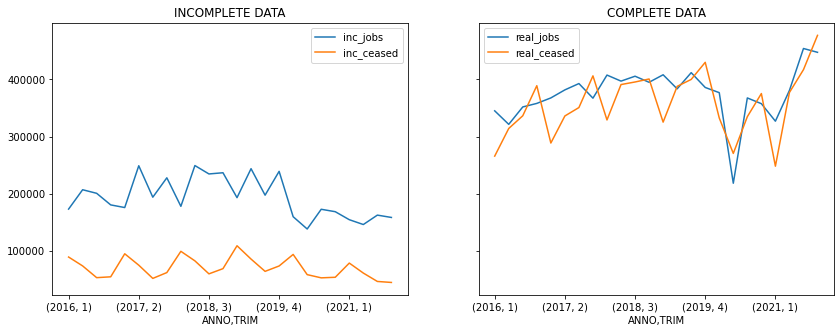

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)

ax[0].set_title('INCOMPLETE DATA')
jmarket_inc.plot(ax=ax[0])

ax[1].set_title('COMPLETE DATA')
jmarket_real.plot(ax=ax[1])
plt.show()

### This data is correct! but...

- it starts from 2016
- it's grouped by trimester

#### So, is it really usable for predictions? We have only 16 training data points :(

# IDEA:

If the _incomplete_ and the _complete_ series are strongly correlated, then we can just scale the incomplete data!



## Correlation on "Avviamenti" (we're interested in 0-lag)

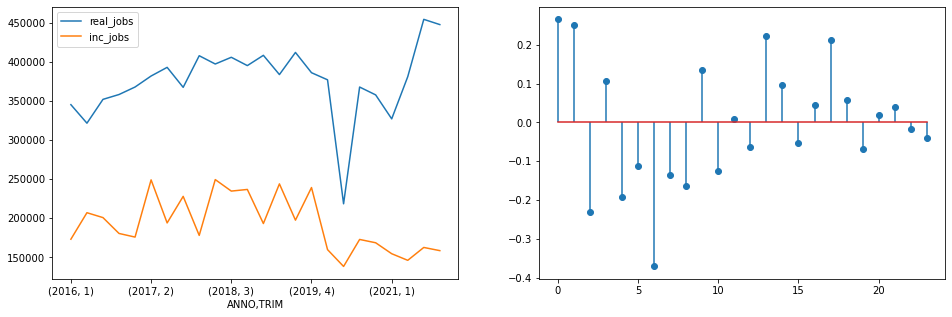

In [114]:
import statsmodels.api as sm

def corr(ds, key1, key2):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    ds[[key1, key2]].plot(ax=plt.gca())
    plt.subplot(1,2,2)
    plt.stem(sm.tsa.stattools.ccf(ds[key1], ds[key2], adjusted=False))
    plt.show()
        
corr(jmarket, 'real_jobs', 'inc_jobs')

This doesn't look good!

## Correlation on "Cessazioni"

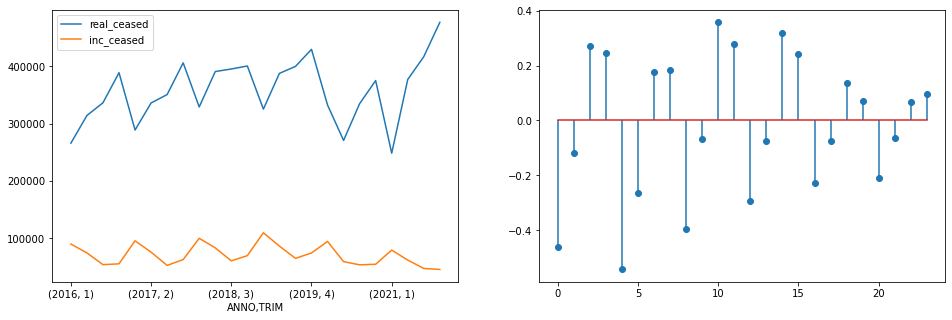

In [115]:
corr(jmarket, 'real_ceased', 'inc_ceased')

Doesn't look good either :(

## "Tempo Indeterminato" contracts probably follow different logics
### And probably *New* and *Ceased* contracts are less affected by the day of the month

Let's try that...

In [116]:
def prepare_dataset(path): 
    ds = pd.read_csv(path)
    ds["DATA"] = pd.to_datetime(ds["DATA"], dayfirst=True, errors="coerce")
    ds = ds.sort_values("DATA", ignore_index=True)
        
    # From previous labs we already know there is one record with invalid date, 
    # let's remove it
    ds = ds[ds['DATA'].notna()]
    
    # Creating column MESE e ANNO
    ds['MESE'] = ds['DATA'].dt.month
    ds['ANNO'] = ds['DATA'].dt.year
    
    # Create column TRIM so that data is divided in trimesters
    ds['TRIM'] = ds['MESE'].apply(lambda x : math.ceil(x/3))
    
    # Select only "Tempo Indeterminato" jobs
    ds = ds[ds['CONTRATTO'].isin(["LAVORO A TEMPO INDETERMINATO",
                                  "LAVORO DOMESTICO A TEMPO INDETERMINATO",
                                  "LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIONE) A TEMPO INDETERMINATO",
                                  "LAVORO DIPENDENTE NELLA P.A. A TEMPO INDETERMINATO",
                                  "CONTRATTO DI AGENZIA A TEMPO INDETERMINATO",
                                  "LAVORO NELLO SPETTACOLO A TEMPO INDETERMINATO",
                                  "ASSOCIAZIONE IN PARTECIPAZIONE A TEMPO INDETERMINATO",
                                  "LAVORO MARITTIMO A TEMPO INDETERMINATO",
                                  "LAVORO RIPARTITO A TEMPO INDETERMINATO",
                                  "Lavoro a tempo indeterminato con piattaforma"])]
    
    trims = [(x, y) for x in range(2016, 2022) for y in range(1, 5)]
    return ds.groupby(["ANNO", "TRIM"]).size().reindex(trims)

jobs_ind = prepare_dataset(data_path + "Rapporti_di_lavoro_attivati.csv")
ceased_ind = prepare_dataset(data_path + "Rapporti_di_lavoro_cessati.csv")

In [117]:
def prepare_dataset(path): 
    ds = pd.read_csv(path, sep=';')
    
    # Create column ANNO
    ds['ANNO'] = ds['Trimestre'].apply(lambda x: int(x[-4:]))
    
    # Create column TRIM so that data is divided in trimesters
    def trimester(x):
        if x[0:5] == 'Primo':
            return 1
        elif x[0:7] == 'Secondo':
            return 2
        elif x[0:5] == 'Terzo':
            return 3
        else:
            return 4
    
    ds['TRIM'] = ds['Trimestre'].apply(trimester)
    
    # Select only "Tempo Indeterminato" jobs
    ds = ds[ds['Contratto'].isin(["Tempo Indeterminato"])]
    
    # Fix column names
    ds.rename(str.upper, axis='columns', inplace=True)
    
    # Groupby and reindex
    trims = [(x, y) for x in range(2016, 2022) for y in range(1, 5)]
    return ds.groupby(["ANNO", "TRIM"]).sum().reindex(trims)

q_jobs_ind = prepare_dataset(data_path + "Quadrante_avviamenti_contratto.csv")
q_ceased_ind = prepare_dataset(data_path + "Quadrante_cessazioni_contratto.csv")

In [119]:
jmarket_ind = pd.concat([jobs_ind, ceased_ind, q_jobs_ind, q_ceased_ind], axis=1).rename(columns={
               0: "inc_jobs", 
               1: "inc_ceased", 
               "AVVIAMENTI": "real_jobs", 
               "CESSAZIONI": "real_ceased"})

### "Cessazioni" still look awful

Probably "Tempo Indeterminato" contracts also tend to be terminated near the end of the month

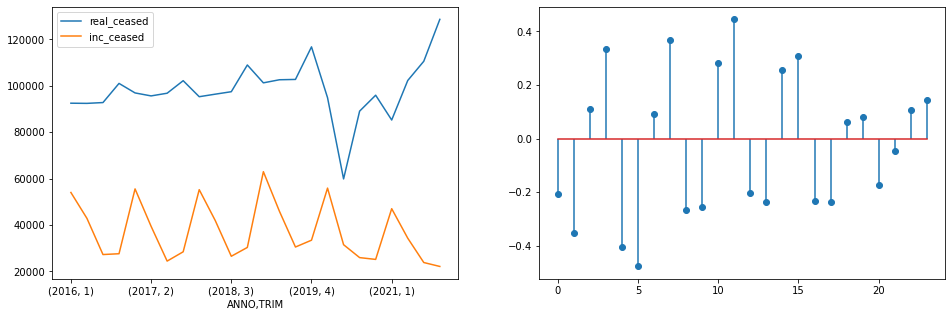

In [121]:
corr(jmarket_ind, 'real_ceased', 'inc_ceased')

### "Avviamenti" have improved a lot

A 0.6 correlation is not very strong, but we can work with that...

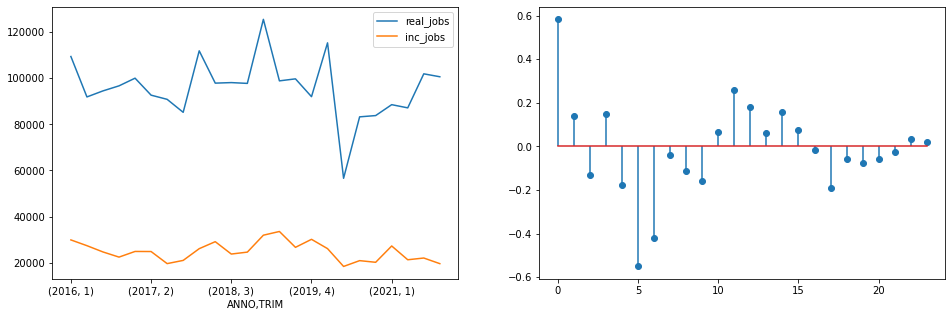

In [120]:
corr(jmarket_ind, 'real_jobs', 'inc_jobs')

#### ... or at least let's pretend we can ;)

## What changed?

Whereas ceased contracts still have a bad correlation, started contracts have a pretty decent one of 0.6, which probably is still not good enough to make predictions...

### ...but let's do it anyway, because why not!

### Let's load the (incomplete) dataset, filtering only Tempo Indeterminato contracts, then let's...

- join it with the Ateco codes, grouping activities by macro-sectors
- generalize age, studies and citizenship into wider categories

In [2]:
#Load Ateco
ateco = pd.read_csv(data_path + "CodiciAteco.csv")
ateco["Descrizione_ateco"] = ateco["Descrizione_ateco"].str.split(" - ", expand=True)[1]
ateco[['Ateco1', 'Ateco2', 'Ateco3']] = ateco["Codice_ateco"].str.split(".", expand=True)
ateco.drop_duplicates(subset=['Descrizione_ateco'], inplace=True)
ateco.drop(["_id", "Codice_ateco"], axis=1, inplace=True)

def prepare_dataset(path): 
    ds = pd.read_csv(path)
    ds["DATA"] = pd.to_datetime(ds["DATA"], dayfirst=True, errors="coerce")
    ds = ds.sort_values("DATA", ignore_index=True)
        
    # From previous labs we already know there is one record with invalid date, 
    # let's remove it
    ds = ds[ds['DATA'].notna()]
    
    # Creating column MESE e ANNO
    ds['MESE'] = ds['DATA'].dt.month
    ds['ANNO'] = ds['DATA'].dt.year
    
    # Select only "Tempo Indeterminato" jobs
    ds = ds[ds['CONTRATTO'].isin(["LAVORO A TEMPO INDETERMINATO",
                                  "LAVORO DOMESTICO A TEMPO INDETERMINATO",
                                  "LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIONE) A TEMPO INDETERMINATO",
                                  "LAVORO DIPENDENTE NELLA P.A. A TEMPO INDETERMINATO",
                                  "CONTRATTO DI AGENZIA A TEMPO INDETERMINATO",
                                  "LAVORO NELLO SPETTACOLO A TEMPO INDETERMINATO",
                                  "ASSOCIAZIONE IN PARTECIPAZIONE A TEMPO INDETERMINATO",
                                  "LAVORO MARITTIMO A TEMPO INDETERMINATO",
                                  "LAVORO RIPARTITO A TEMPO INDETERMINATO",
                                  "Lavoro a tempo indeterminato con piattaforma"])]
    
    # Data is collected consistenty starting by 2010
    ds = ds[(ds['ANNO'] >= 2010) & (ds['ANNO'] <= 2021)]
    
    # Add Ateco category and group categories by the 
    # classification found here: https://codiceateco.it/sezioni
    ds = ds.join(ateco.set_index("Descrizione_ateco"), on="SETTOREECONOMICODETTAGLIO")
    ds = ds[ds['Ateco1'].notna()]
    ds["GRUPPOSETTORE"] = np.nan
    ds['Ateco1'] = ds['Ateco1'].astype('int')
    ds.loc[(ds["Ateco1"] >= 1) & (ds["Ateco1"] <= 3), "GRUPPOSETTORE"] = "AGRICOLTURA, SILVICOLTURA E PESCA"
    ds.loc[(ds["Ateco1"] >= 5) & (ds["Ateco1"] <= 9), "GRUPPOSETTORE"] = "ESTRAZIONE DI MINERALI DA CAVE E MINIERE"
    ds.loc[(ds["Ateco1"] >= 10) & (ds["Ateco1"] <= 33), "GRUPPOSETTORE"] = "ATTIVITÀ MANIFATTURIERE"
    ds.loc[(ds["Ateco1"] >= 35) & (ds["Ateco1"] <= 35), "GRUPPOSETTORE"] = "FORNITURA DI ENERGIA ELETTRICA, GAS, VAPORE E ARIA CONDIZIONATA"
    ds.loc[(ds["Ateco1"] >= 36) & (ds["Ateco1"] <= 39), "GRUPPOSETTORE"] = "FORNITURA DI ACQUA - RETI FOGNARIE, ATTIVITÀ DI GESTIONE DEI RIFIUTI E RISANAMENTO"
    ds.loc[(ds["Ateco1"] >= 41) & (ds["Ateco1"] <= 43), "GRUPPOSETTORE"] = "COSTRUZIONI"
    ds.loc[(ds["Ateco1"] >= 45) & (ds["Ateco1"] <= 47), "GRUPPOSETTORE"] = "COMMERCIO ALL'INGROSSO E AL DETTAGLIO - RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI"
    ds.loc[(ds["Ateco1"] >= 49) & (ds["Ateco1"] <= 53), "GRUPPOSETTORE"] = "TRASPORTO E MAGAZZINAGGIO"
    ds.loc[(ds["Ateco1"] >= 55) & (ds["Ateco1"] <= 56), "GRUPPOSETTORE"] = "ATTIVITÀ DEI SERVIZI DI ALLOGGIO E DI RISTORAZIONE"
    ds.loc[(ds["Ateco1"] >= 58) & (ds["Ateco1"] <= 63), "GRUPPOSETTORE"] = "SERVIZI DI INFORMAZIONE E COMUNICAZIONE"
    ds.loc[(ds["Ateco1"] >= 64) & (ds["Ateco1"] <= 66), "GRUPPOSETTORE"] = "ATTIVITÀ FINANZIARIE E ASSICURATIVE"
    ds.loc[(ds["Ateco1"] >= 68) & (ds["Ateco1"] <= 68), "GRUPPOSETTORE"] = "ATTIVITA' IMMOBILIARI"
    ds.loc[(ds["Ateco1"] >= 69) & (ds["Ateco1"] <= 75), "GRUPPOSETTORE"] = "ATTIVITÀ PROFESSIONALI, SCIENTIFICHE E TECNICHE"
    ds.loc[(ds["Ateco1"] >= 77) & (ds["Ateco1"] <= 82), "GRUPPOSETTORE"] = "NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPORTO ALLE IMPRESE"
    ds.loc[(ds["Ateco1"] >= 84) & (ds["Ateco1"] <= 84), "GRUPPOSETTORE"] = "AMMINISTRAZIONE PUBBLICA E DIFESA - ASSICURAZIONE SOCIALE OBBLIGATORIA"
    ds.loc[(ds["Ateco1"] >= 85) & (ds["Ateco1"] <= 85), "GRUPPOSETTORE"] = "ISTRUZIONE"
    ds.loc[(ds["Ateco1"] >= 86) & (ds["Ateco1"] <= 88), "GRUPPOSETTORE"] = "SANITA' E ASSISTENZA SOCIALE"
    ds.loc[(ds["Ateco1"] >= 90) & (ds["Ateco1"] <= 93), "GRUPPOSETTORE"] = "ATTIVITÀ ARTISTICHE, SPORTIVE, DI INTRATTENIMENTO E DIVERTIMENTO"
    ds.loc[(ds["Ateco1"] >= 94) & (ds["Ateco1"] <= 96), "GRUPPOSETTORE"] = "ALTRE ATTIVITÀ DI SERVIZI"
    ds.loc[(ds["Ateco1"] >= 97) & (ds["Ateco1"] <= 98), "GRUPPOSETTORE"] = "ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI DI LAVORO PER PERSONALE DOMESTICO; PRODUZIONE DI BENI E SERVIZI INDIFFERENZIATI PER USO PROPRIO DA PARTE DI FAMIGLIE E CONVIVENZE"
    ds.loc[(ds["Ateco1"] >= 99) & (ds["Ateco1"] <= 99), "GRUPPOSETTORE"] = "ORGANIZZAZIONI ED ORGANISMI EXTRATERRITORIALI"
    ds = ds[ds['GRUPPOSETTORE'].notna()]
    
    # Età to age range
    bins = [-1, 24, 40, 55, 200]
    labels = ['15-24', '25-40', '41-55', '56+']
    ds["ETA"] = pd.cut(ds["ETA"], bins=bins, labels=labels, right=False)
    
    # Making ITALIANO a boolean column
    ds.loc[ds["ITALIANO"] != "ITALIA", "ITALIANO"] = "NO"
    ds.loc[ds["ITALIANO"] == "ITALIA", "ITALIANO"] = "SI"
    
    # Grouping TITOLOSTUDIO
    ds.loc[ds["TITOLOSTUDIO"].isin(["LICENZA ELEMENTARE"]), "TITOLOSTUDIO"] = "ELEMENTARE"
    ds.loc[ds["TITOLOSTUDIO"].isin(["LICENZA MEDIA"]), "TITOLOSTUDIO"] = "SECONDARIA INFERIORE"
    ds.loc[ds["TITOLOSTUDIO"].isin([
        "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
        "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()"
    ]), "TITOLOSTUDIO"] = "SECONDARIA SUPERIORE"
    ds.loc[ds["TITOLOSTUDIO"].isin(["NESSUN TITOLO DI STUDIO"]), "TITOLOSTUDIO"] = "SCONOSCIUTO"
    ds.loc[~ds["TITOLOSTUDIO"].isin([
        "ELEMENTARE",
        "SECONDARIA INFERIORE",
        "SECONDARIA SUPERIORE",
        "SCONOSCIUTO"
    ]), "TITOLOSTUDIO"] = "TERZIARIA"
    ds = ds[ds['TITOLOSTUDIO'] != "SCONOSCIUTO"]
    
    # Return without unwanted columns
    return ds.drop(["CONTRATTO", "DATA", "Ateco1", "Ateco2", "Ateco3", "MODALITALAVORO", "SETTOREECONOMICODETTAGLIO"], axis=1)

permanent_jobs = prepare_dataset(data_path + "Rapporti_di_lavoro_attivati.csv")

In [124]:
permanent_jobs

,GENERE,ETA,TITOLOSTUDIO,PROVINCIAIMPRESA,ITALIANO,MESE,ANNO,GRUPPOSETTORE
399170,F,41-55,TERZIARIA,MILANO,SI,1,2010,SANITA' E ASSISTENZA SOCIALE
399233,M,41-55,SECONDARIA SUPERIORE,CREMONA,SI,1,2010,"AGRICOLTURA, SILVICOLTURA E PESCA"
399291,M,25-40,SECONDARIA INFERIORE,BERGAMO,SI,1,2010,TRASPORTO E MAGAZZINAGGIO
399292,M,56+,SECONDARIA SUPERIORE,PAVIA,SI,1,2010,"AGRICOLTURA, SILVICOLTURA E PESCA"
399294,F,25-40,SECONDARIA SUPERIORE,MILANO,SI,1,2010,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
...,...,...,...,...,...,...,...,...
9579723,F,41-55,SECONDARIA SUPERIORE,MANTOVA,SI,12,2021,ALTRE ATTIVITÀ DI SERVIZI
9579724,F,25-40,SECONDARIA SUPERIORE,BRESCIA,NO,12,2021,COMMERCIO ALL'INGROSSO E AL DETTAGLIO - RIPARA...
9579731,M,15-24,SECONDARIA SUPERIORE,MILANO,SI,12,2021,SERVIZI DI INFORMAZIONE E COMUNICAZIONE
9579739,F,41-55,SECONDARIA SUPERIORE,BRESCIA,SI,12,2021,SANITA' E ASSISTENZA SOCIALE


### Here's how it looks like, grouped by year and month

\* The peak at the start of 2015 is probably due to a change in laws regarding *Tempo Indeterminato* jobs at the beginnning of that year.

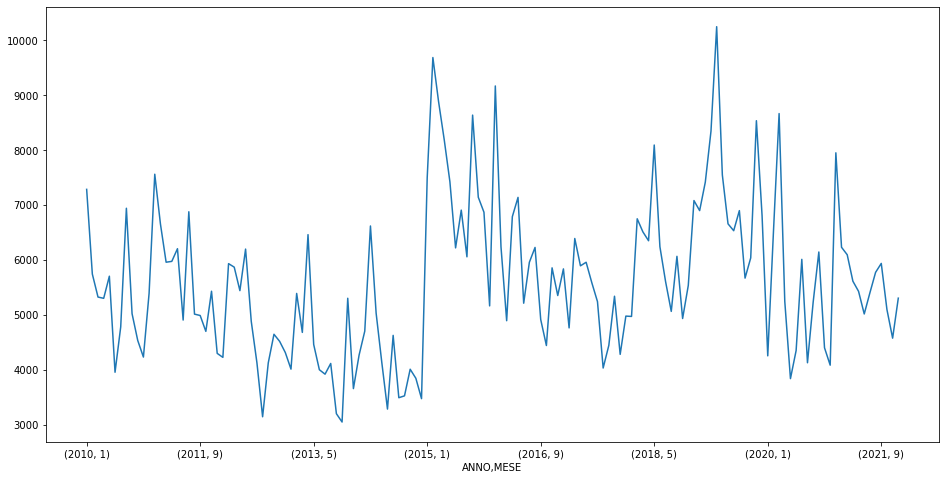

In [129]:
plt.figure(figsize=(16,8))

months = [(x, y) for x in range(2010, 2022) for y in range(1, 13)]
ds = permanent_jobs.groupby(["ANNO", "MESE"]).size().reindex(months)
ds.plot()
plt.show()

### Seasonality

While not well defined, the autocorrelation graphs seem to suggest that there's some 12-month seasonality going on, but not really strong.

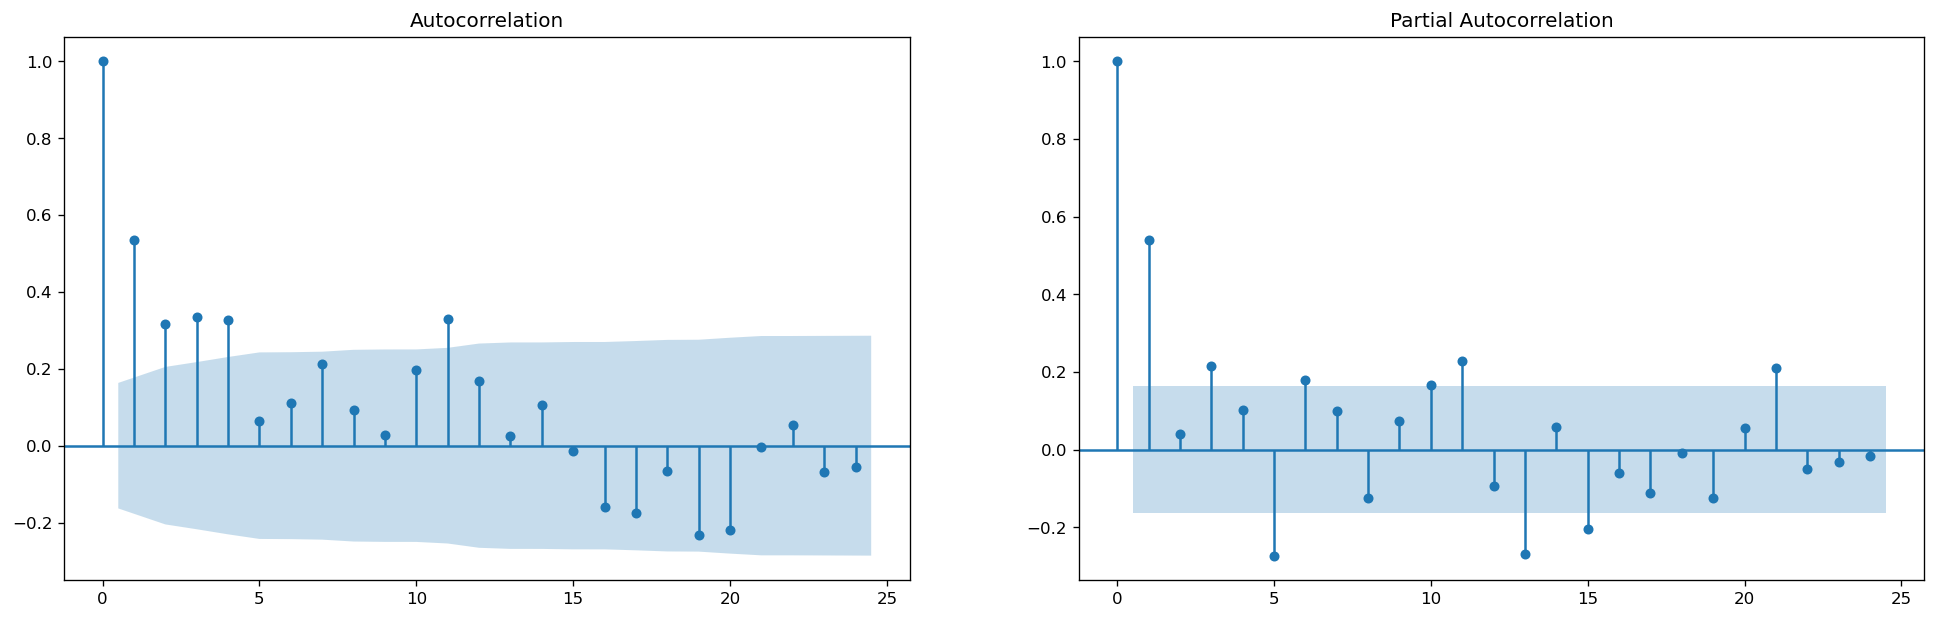

In [136]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def get_ac(ts):
    fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
    plot_acf(ts.to_list(), lags=24, ax=axes[0])
    plot_pacf(ts.to_list(), lags=24, ax=axes[1])
    plt.show()
    
get_ac(ds)

### Seasonal decomposition

Additive and multiplicative decompositions seem to confirm the impression that the time series has a seasonality but not really strong. Neither the additive nor the multiplicative models seem to fit perfectly.

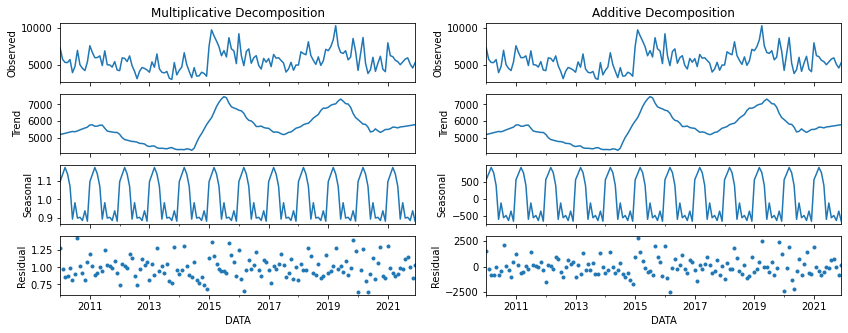

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

def plotseasonal(res, axes, title):
    axes[0].title.set_text(title)
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, style='.')
    axes[3].set_ylabel('Residual')

def seas_dec(ts):
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

    fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(14,5))
    
    # Plot
    plotseasonal(result_mul, axes[:,0], "Multiplicative Decomposition")
    plotseasonal(result_add, axes[:,1], "Additive Decomposition")
    plt.show()
    
ts = ds.reset_index().reset_index()
ts["DATA"] = ts["ANNO"].astype(str) + "/" + ts["MESE"].astype(str) + "/01"
ts["DATA"] = pd.to_datetime(ts["DATA"])
ts = ts.set_index("DATA")[0]
    
seas_dec(ts)

### Stationarity

The first derivative of the series appears to be stationary.

In [154]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(ts)
print('Series:')
print('\tADF Statistic: %f' % results[0])
print('\tp-value: %f' % results[1])
print()

results = adfuller(ts.diff().dropna())
print('First derivative:')
print('\tADF Statistic: %f' % results[0])
print('\tp-value: %f' % results[1])

Series:
	ADF Statistic: -2.573104
	p-value: 0.098685

First derivative:
	ADF Statistic: -3.800374
	p-value: 0.002903


# Let's do some prediction with SARIMA

We will use pre-COVID data for finding the best parameters.

In [6]:
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
import warnings
warnings.filterwarnings('ignore')

def get_arima_pred(ts, column=0, with_plot=False, with_best_values=False, standardize=False):
    # Reindex     
    ts = ts.reindex([(x, y) for x in range(2010, 2022) for y in range(1, 13)])
    
    # Time series standardization
    if(standardize):
        ts = (ts - ts.mean()) / ts.std()
    
    # Adjust dataset format
    ts = ts.reset_index().reset_index()
    ts["DATA"] = ts["ANNO"].astype(str) + "/" + ts["MESE"].astype(str) + "/01"
    ts["DATA"] = pd.to_datetime(ts["DATA"])
    ts = ts.set_index("DATA")[column]
    ts = ts.fillna(0)
    ts = ts.rename('y')

    # Remove covid period
    ts_no_covid = ts[:'2020-01-01']

    model = auto_arima(   ts_no_covid,
                          information_criterion='aic',
                          test='adf',
                          max_p=3,
                          max_q=3,
                          d=ndiffs(ts_no_covid),
                          D=nsdiffs(ts_no_covid, 12),
                          seasonal=True,
                          m=12,
                          trace=False,
                          error_action="ignore",
                          suppress_warnings=True,
                          stepwise=True,
                          with_intercept=True)
    results = model.fit_predict(ts_no_covid, n_periods=24, return_conf_int=True)

    if(with_best_values):
        print(f"{model.order}{model.seasonal_order}{' with intercept' if model.with_intercept else '' }")

    # Create SARIMA mean forecast
    upper = [x[1] for x in results[1]]
    lower = [x[0] for x in results[1]]

    if(with_plot):
        # Plot mean SARIMA predictions
        fig,ax = plt.subplots(1,1,figsize=(20,8))

        plt.plot(ts, label='original')
        plt.plot(ts['2020-01-01':].index.to_list(), results[0], label='SARIMA', c="r")
        plt.fill_between(ts['2019-12-01':].index.to_list(), 
                         [ts_no_covid[-2]]+lower,[ts_no_covid[-2]]+upper,
                         color='pink')
        plt.plot(pd.DatetimeIndex(['2019-12-01', '2020-01-01']), [ts_no_covid[-2], results[0][0]], c="r", ls='--')
        plt.xlabel('Date')
        plt.ylabel('New jobs')
        plt.legend()
        plt.show()
        
    return ts['2020-01-01':].sum() - results[0].sum()

(2, 1, 3)(1, 0, 1, 12) with intercept


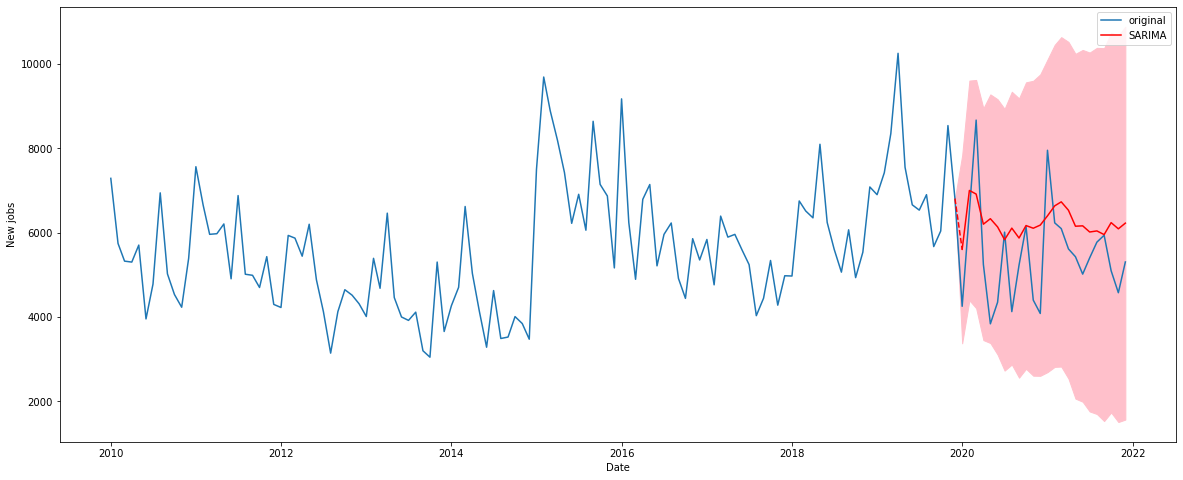

Difference in jobs (compared to forecasted mean): -18321.11


In [7]:
ds = permanent_jobs.groupby(["ANNO", "MESE"]).size()
difference = get_arima_pred(ds, with_plot=True, with_best_values=True)

print(f"Difference in jobs (compared to forecasted mean): {round(difference, 2)}")

In [236]:
def analyze_ts(ds, plot=False, sort=True, standardize=True):
    for _ in range(ds.index.nlevels - 2):
        ds = ds.unstack()

    results = []
    for col in pd.DataFrame(ds).columns:
        try:
            results.append((col, get_arima_pred(ds, standardize=standardize, column=col)))
        except:
            result.append(None)

    if(sort):
        results = sorted(results,  key=lambda x: x[1])
    plain_result = results
    
    if(plot):    
        results = list(zip(*results))
        plt.figure(figsize=(14,5))
        plt.xticks(rotation=60, ha="right")
        plt.axhline(y = 0, color = 'r', linestyle = '-')
        plt.grid()

        x = [(str(x)[:50] + '...') if len(str(x)) > 50 else str(x) for x in results[0]]
        y = results[1]
        plt.scatter(x, y)
        plt.show()

        return x,y
        
    return plain_result

## We can automate this analysis on all the possible values of one or more attributes of the dataset, to see how they compare (\*):

\* standardized series

Here's for example PROVINCIAIMPRESA

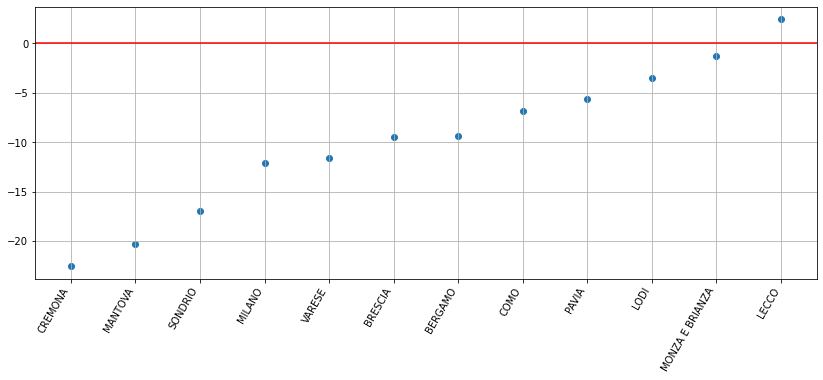

In [246]:
_ = analyze_ts(permanent_jobs.groupby(["ANNO", "MESE", "PROVINCIAIMPRESA"]).size(), plot=True)

Or GRUPPOSETTORE

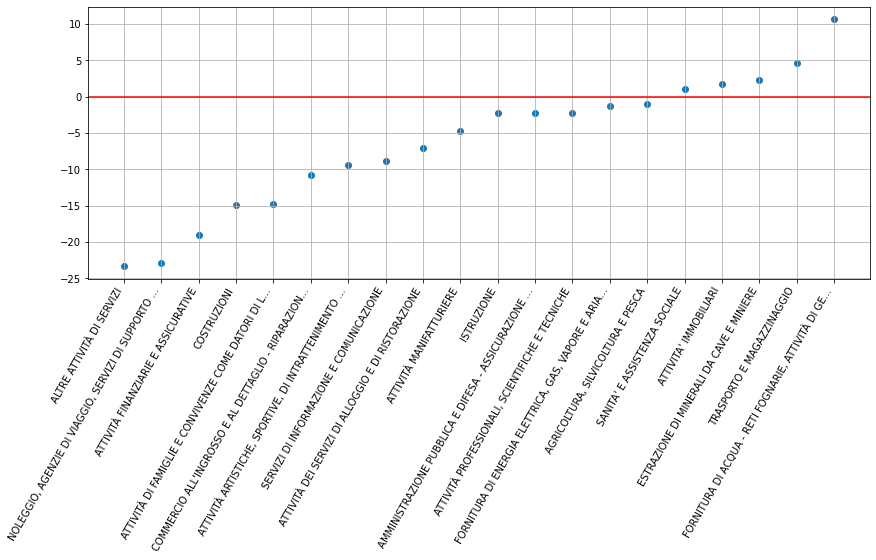

In [251]:
_ = analyze_ts(permanent_jobs.groupby(["ANNO", "MESE", "GRUPPOSETTORE"]).size(), plot=True)

Or something more complicated like ITALIANO + GENERE + ETA

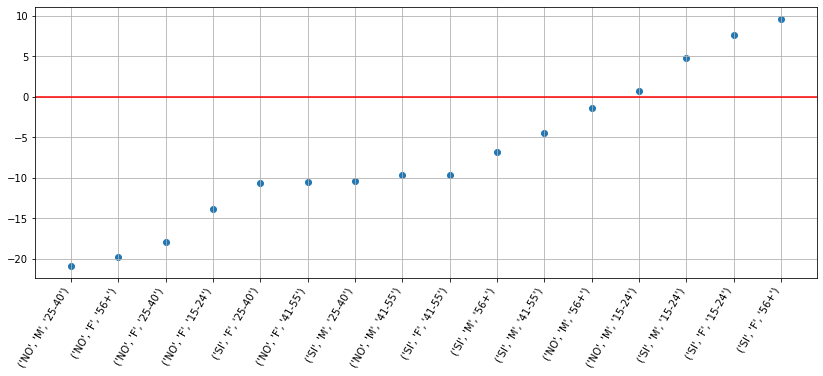

In [253]:
_ = analyze_ts(permanent_jobs.groupby(["ANNO", "MESE", "ETA", "GENERE", "ITALIANO"]).size(), plot=True)

## Let's also setup a LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
def LSTM_predict(ts, column=0, with_plot=True):        
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Adjust dataset format
    months = [(x, y) for x in range(2010, 2022) for y in range(1, 13)]
    ts = ts.reindex(months, fill_value=0)

    for _ in range(ts.index.nlevels - 2):
            ts = ts.unstack()

    ts = ts.reset_index().reset_index()
    ts["DATA"] = ts["ANNO"].astype(str) + "/" + ts["MESE"].astype(str) + "/01"
    ts["DATA"] = pd.to_datetime(ts["DATA"])
    ts = ts.set_index("DATA")[column]
    ts = ts.fillna(0)

    ts_no_covid = ts[:'2020-01-01']
    ts_no_covid = scaler.fit_transform(ts_no_covid.values.astype('float32').reshape(-1, 1))

    train_size = int(len(ts_no_covid) * 0.75)
    test_size = len(ts_no_covid) - train_size
    train, test = ts_no_covid[0:train_size,:], ts_no_covid[train_size:len(ts_no_covid),:]


    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    # Create and reshape datasets
    look_back = 24
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test,look_back)
    tsX, tsY = create_dataset(ts_no_covid, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    tsX = np.reshape(tsX, (tsX.shape[0], 1, tsX.shape[1]))

    # LSTM model
    model = Sequential()
    model.add(LSTM(16, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=0)

    # Prediction
    prediction = model.predict(tsX)
    prediction = scaler.inverse_transform(prediction)[:,0]
    prediction = pd.Series(prediction[-24:], ts['2020-01-01':].index)

    if(with_plot):
        # Plot
        plt.figure(figsize=(14,5))
        plt.plot(ts, label="Series")
        plt.plot(prediction, label="Prediction")
        plt.legend()
        plt.show()
    
    return prediction

3/3 [==============================] - 0s 2ms/step


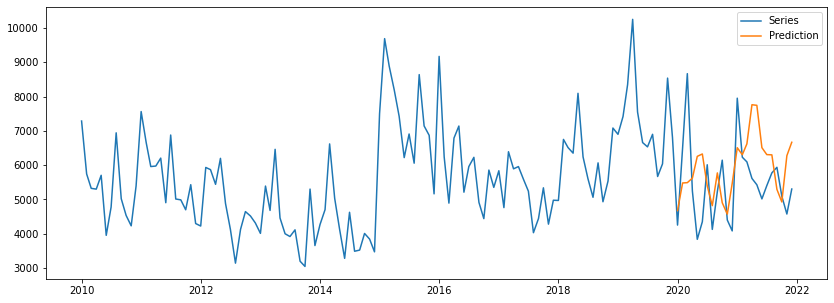

In [14]:
_ = LSTM_predict(permanent_jobs.groupby(["ANNO", "MESE"]).size())

# We can play with these concepts in the dashboard...